# Imputation using UNCURL

Here, we will test imputation of missing data.

In [1]:
%matplotlib inline
import random

import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io
from scipy import sparse
import uncurl

## Loading data

There are two datasets: 'z' is the Zeisel (2015) dataset, with 7 cell types. '10x' is a subset of pooled data from 8 different PBMC types, 50 cells from each type.

In [2]:
data_z = scipy.io.loadmat('../data/GSE60361_dat.mat')
data_10x = scipy.io.loadmat('../data/10x_pooled_400.mat')

In [65]:
data_z_mat = data_z['Dat']
genes_z = uncurl.max_variance_genes(data_z_mat, 1, 0.2)
data_z_mat = data_z_mat[genes_z, :]

In [66]:
data_10x_mat = data_10x['data']
genes_10x = uncurl.max_variance_genes(data_10x_mat, 1, 0.2)
data_10x_mat = data_10x_mat[genes_10x, :]

In [67]:
data_z_mat.shape

(3994, 753)

In [68]:
data_10x_mat.shape

(3969, 400)

## Artificially inducing missing values

One problem is that sometimes, all values for a gene are set to zero, which completely breaks uncurl. So we'll try not including these genes?

In [69]:
p_impute = 0.2

In [70]:
data_z_mat = sparse.coo_matrix(data_z_mat)
data_10x_mat = sparse.coo_matrix(data_10x_mat)


indices_z = random.sample(range(len(data_z_mat.data)), int(p_impute*len(data_z_mat.data)))
indices_10x = random.sample(range(len(data_10x_mat.data)), int(p_impute*len(data_10x_mat.data)))

# save deleted data for comparison
true_values_z = data_z_mat.data[indices_z]
sampled_rows_z = data_z_mat.row[indices_z]
sampled_cols_z = data_z_mat.col[indices_z]

true_values_10x = data_10x_mat.data[indices_10x]
sampled_rows_10x = data_10x_mat.row[indices_10x]
sampled_cols_10x = data_10x_mat.col[indices_10x]

# do the data deletion
data_z_mat.data[indices_z] = 0
data_z_mat.eliminate_zeros()
data_z_mat = sparse.csc_matrix(data_z_mat)

data_10x_mat.data[indices_10x] = 0
data_10x_mat.eliminate_zeros()
data_10x_mat = sparse.csc_matrix(data_10x_mat)

In [71]:
(data_z_mat.max(1).toarray() == 0).sum()

0

In [72]:
(data_10x_mat.max(1).toarray() == 0).sum()

1

## Perform UNCURL for imputation

In [14]:
k_z = 7
%time M_z, W_z, ll = uncurl.poisson_estimate_state(data_z_mat, k_z, threads=4, disp=False)

CPU times: user 5min 3s, sys: 3.96 s, total: 5min 7s
Wall time: 1min 22s


In [15]:
k_10x = 8
%time M_10x, W_10x, ll = uncurl.poisson_estimate_state(data_10x_mat, k_10x, threads=4, disp=False)

CPU times: user 58.5 s, sys: 840 ms, total: 59.4 s
Wall time: 16.2 s


## Imputation with MW

In [25]:
def calculate_imputation_error(sampled_rows, sampled_cols, indices, true_values, new_matrix):
    """
    Returns imputed values, rmse, correlation, spearman.
    """
    imputed_values = []
    for i in range(len(indices)):
        imputed_value = new_matrix[sampled_rows[i], sampled_cols[i]]
        imputed_values.append(imputed_value)
    imputed_values = np.array(imputed_values)
    rmse = np.sqrt(np.mean(((imputed_values - true_values)/true_values)**2))
    print('rmse:', rmse)

    correlation = np.corrcoef(imputed_values, true_values)[0,1]
    print('correlation:', correlation)

    spearman = scipy.stats.spearmanr(imputed_values, true_values).correlation
    print('spearman:', spearman)
    return imputed_values, rmse, correlation, spearman

In [28]:
print('Results for 10x imputation with UNCURL:')
MW = M_10x.dot(W_10x)
imputed_vals, rmse, corr, sp = calculate_imputation_error(sampled_rows_10x,
                                               sampled_cols_10x,
                                               indices_10x,
                                               true_values_10x, MW)

print()
print('Results for Zeisel imputation with UNCURL:')
MW = M_z.dot(W_z)
imputed_vals, rmse, corr, sp = calculate_imputation_error(sampled_rows_z,
                                               sampled_cols_z,
                                               indices_z,
                                               true_values_z, MW)

Results for 10x imputation with UNCURL:
rmse: 0.7906967120508817
correlation: 0.8800924622879358
spearman: 0.7364014632187664

Results for Zeisel imputation with UNCURL:
rmse: 1.0044763189323742
correlation: 0.9212627053022824
spearman: 0.5802298048812948


## Imputation test with MAGIC

MAGIC is a scRNA-seq preprocessing method.

TODO: perhaps include other methods such as scImpute?

In [18]:
import magic
import pandas as pd

In [19]:
table_z = pd.DataFrame(data_z_mat.toarray().T)

table_z.columns = table_z.columns.astype(str)
scdata = magic.mg.SCData(table_z, data_type='sc-seq')
scdata = scdata.normalize_scseq_data()
scdata.run_magic(n_pca_components=k_z, random_pca=True,
        t=6, k=30, ka=10, epsilon=1, rescale_percent=99)
magic_output_z = scdata.magic.data.as_matrix().T

In [21]:
table_10x = pd.DataFrame(data_10x_mat.toarray().T)
table_10x.columns = table_10x.columns.astype(str)
scdata = magic.mg.SCData(table_10x, data_type='sc-seq')
scdata = scdata.normalize_scseq_data()
scdata.run_magic(n_pca_components=k_10x, random_pca=True,
        t=6, k=30, ka=10, epsilon=1, rescale_percent=99)
magic_output_10x = scdata.magic.data.as_matrix().T

doing PCA
Computing distances
Autotuning distances
Computing kernel
MAGIC: L_t = L^t
MAGIC: data_new = L_t * data


In [30]:
print('Results for 10x imputation with Magic:')
MW = magic_output_10x
imputed_vals, rmse, corr, sp = calculate_imputation_error(sampled_rows_10x,
                                               sampled_cols_10x,
                                               indices_10x,
                                               true_values_10x, MW)

Results for 10x imputation with Magic:
rmse: 1.1998896634245035
correlation: 0.7263493332650599
spearman: 0.7038290195917589


In [29]:
print('Results for Zeisel imputation with Magic:')
imputed_values = []
MW = magic_output_z
imputed_vals, rmse, corr, sp = calculate_imputation_error(sampled_rows_z,
                                               sampled_cols_z,
                                               indices_z,
                                               true_values_z, MW)

Results for Zeisel imputation with Magic:
rmse: 4.177598017403086
correlation: 0.7366802470454831
spearman: 0.49058997430447454


## Try with varying missing value fractions

In [74]:
p_impute_vals = [0.2, 0.1, 0.05, 0.01, 0.005, 0.001]
results = pd.DataFrame(columns=['dataset', 'method', 'metric', 'p_impute'])
data_points = []

In [75]:
for p_impute in p_impute_vals:
    print()
    print('p_impute:', str(p_impute))
    data_z_mat = data_z['Dat']
    genes_z = uncurl.max_variance_genes(data_z_mat, 1, 0.2)
    data_z_mat = data_z_mat[genes_z, :]
    data_10x_mat = data_10x['data']
    genes_10x = uncurl.max_variance_genes(data_10x_mat, 1, 0.2)
    data_10x_mat = data_10x_mat[genes_10x, :]
    
    data_z_mat = sparse.coo_matrix(data_z_mat)
    data_10x_mat = sparse.coo_matrix(data_10x_mat)

    indices_z = random.sample(range(len(data_z_mat.data)), int(p_impute*len(data_z_mat.data)))
    indices_10x = random.sample(range(len(data_10x_mat.data)), int(p_impute*len(data_10x_mat.data)))

    # save deleted data for comparison
    true_values_z = data_z_mat.data[indices_z]
    sampled_rows_z = data_z_mat.row[indices_z]
    sampled_cols_z = data_z_mat.col[indices_z]

    true_values_10x = data_10x_mat.data[indices_10x]
    sampled_rows_10x = data_10x_mat.row[indices_10x]
    sampled_cols_10x = data_10x_mat.col[indices_10x]

    # do the data deletion
    data_z_mat.data[indices_z] = 0
    data_z_mat.eliminate_zeros()
    data_z_mat = sparse.csc_matrix(data_z_mat)

    data_10x_mat.data[indices_10x] = 0
    data_10x_mat.eliminate_zeros()
    data_10x_mat = sparse.csc_matrix(data_10x_mat)
    
    # run uncurl
    M_10x, W_10x, ll = uncurl.poisson_estimate_state(data_10x_mat, k_10x, threads=4, disp=False)
    M_z, W_z, ll = uncurl.poisson_estimate_state(data_z_mat, k_z, threads=4, disp=False)
    
    print('Results for 10x imputation with UNCURL:')
    MW = M_10x.dot(W_10x)
    imputed_vals, rmse, corr, sp = calculate_imputation_error(sampled_rows_10x,
                                               sampled_cols_10x,
                                               indices_10x,
                                               true_values_10x, MW)
    data_points.append(['10x', 'uncurl', 'rmse', rmse])
    data_points.append(['10x', 'uncurl', 'corr', corr])
    data_points.append(['10x', 'uncurl', 'sp', sp])

    print()
    print('Results for Zeisel imputation with UNCURL:')
    MW = M_z.dot(W_z)
    imputed_vals, rmse, corr, sp = calculate_imputation_error(sampled_rows_z,
                                               sampled_cols_z,
                                               indices_z,
                                               true_values_z, MW)
    data_points.append(['z', 'uncurl', 'rmse', rmse])
    data_points.append(['z', 'uncurl', 'corr', corr])
    data_points.append(['z', 'uncurl', 'sp', sp])
    print()
    
    # run MAGIC
    table_z = pd.DataFrame(data_z_mat.toarray().T)
    table_z.columns = table_z.columns.astype(str)
    scdata = magic.mg.SCData(table_z, data_type='sc-seq')
    scdata = scdata.normalize_scseq_data()
    scdata.run_magic(n_pca_components=k_z, random_pca=True,
        t=6, k=30, ka=10, epsilon=1, rescale_percent=99)
    magic_output_z = scdata.magic.data.as_matrix().T
    
    table_10x = pd.DataFrame(data_10x_mat.toarray().T)
    table_10x.columns = table_10x.columns.astype(str)
    scdata = magic.mg.SCData(table_10x, data_type='sc-seq')
    scdata = scdata.normalize_scseq_data()
    scdata.run_magic(n_pca_components=k_10x, random_pca=True,
        t=6, k=30, ka=10, epsilon=1, rescale_percent=99)
    magic_output_10x = scdata.magic.data.as_matrix().T
    
    print()
    print('Results for 10x imputation with Magic:')
    MW = magic_output_10x
    imputed_vals, rmse, corr, sp = calculate_imputation_error(sampled_rows_10x,
                                               sampled_cols_10x,
                                               indices_10x,
                                               true_values_10x, MW)
    data_points.append(['10x', 'magic', 'rmse', rmse])
    data_points.append(['10x', 'magic', 'corr', corr])
    data_points.append(['10x', 'magic', 'sp', sp])
    
    print()
    print('Results for Zeisel imputation with Magic:')
    imputed_values = []
    MW = magic_output_z
    imputed_vals, rmse, corr, sp = calculate_imputation_error(sampled_rows_z,
                                               sampled_cols_z,
                                               indices_z,
                                               true_values_z, MW)
    data_points.append(['z', 'magic', 'rmse', rmse])
    data_points.append(['z', 'magic', 'corr', corr])
    data_points.append(['z', 'magic', 'sp', sp])
    print()


p_impute: 0.2
Results for 10x imputation with UNCURL:
rmse: 0.8059643145087433
correlation: 0.8611479795903587
spearman: 0.6672606827425385

Results for Zeisel imputation with UNCURL:
rmse: 0.8978511351518204
correlation: 0.7226001015393787
spearman: 0.5793025064635846

doing PCA
Computing distances
Autotuning distances
Computing kernel
MAGIC: L_t = L^t
MAGIC: data_new = L_t * data
doing PCA
Computing distances
Autotuning distances
Computing kernel
MAGIC: L_t = L^t
MAGIC: data_new = L_t * data

Results for 10x imputation with Magic:
rmse: 1.5966648453938486
correlation: 0.7275395421247804
spearman: 0.6290407048624072

Results for Zeisel imputation with Magic:
rmse: 5.156372400513566
correlation: 0.30943024823704435
spearman: 0.4578382314468686


p_impute: 0.1
Results for 10x imputation with UNCURL:
rmse: 0.8061950792793227
correlation: 0.8689945509226106
spearman: 0.6704395452368626

Results for Zeisel imputation with UNCURL:
rmse: 0.9675025117624731
correlation: 0.7465436072936819
sp

In [76]:
results = pd.DataFrame(data_points, columns=['dataset', 'method', 'metric', 'p_impute'])

In [77]:
results.head()

,dataset,method,metric,p_impute
0,10x,uncurl,rmse,0.805964
1,10x,uncurl,corr,0.861148
2,10x,uncurl,sp,0.667261
3,z,uncurl,rmse,0.897851
4,z,uncurl,corr,0.722600


In [78]:
# okay so this was an error... we have to correct the results.
results['value'] = results['p_impute']

In [79]:
results['p_impute'] = [x for y in [[p]*12 for p in p_impute_vals] for x in y]

In [80]:
results.head()

,dataset,method,metric,p_impute,value
0,10x,uncurl,rmse,0.2,0.805964
1,10x,uncurl,corr,0.2,0.861148
2,10x,uncurl,sp,0.2,0.667261
3,z,uncurl,rmse,0.2,0.897851
4,z,uncurl,corr,0.2,0.722600


In [103]:
uncurl_rmse_10x = results[(results.method=='uncurl') &\
                          (results.dataset=='10x') &\
                          (results.metric=='rmse')]
uncurl_rmse_10x = uncurl_rmse_10x[['p_impute', 'value']]

uncurl_corr_10x = results[(results.method=='uncurl') &\
                          (results.dataset=='10x') &\
                          (results.metric=='corr')]
uncurl_corr_10x = uncurl_corr_10x[['p_impute', 'value']]

uncurl_sp_10x = results[(results.method=='uncurl') &\
                          (results.dataset=='10x') &\
                          (results.metric=='sp')]
uncurl_sp_10x = uncurl_sp_10x[['p_impute', 'value']]

uncurl_rmse_z = results[(results.method=='uncurl') &\
                          (results.dataset=='z') &\
                          (results.metric=='rmse')]
uncurl_rmse_z = uncurl_rmse_z[['p_impute', 'value']]

uncurl_corr_z = results[(results.method=='uncurl') &\
                          (results.dataset=='z') &\
                          (results.metric=='corr')]
uncurl_corr_z = uncurl_corr_z[['p_impute', 'value']]

uncurl_sp_z = results[(results.method=='uncurl') &\
                          (results.dataset=='z') &\
                          (results.metric=='sp')]
uncurl_sp_z = uncurl_sp_z[['p_impute', 'value']]

In [100]:
magic_rmse_10x = results[(results.method=='magic') &\
                          (results.dataset=='10x') &\
                          (results.metric=='rmse')]
magic_rmse_10x = magic_rmse_10x[['p_impute', 'value']]

magic_corr_10x = results[(results.method=='magic') &\
                          (results.dataset=='10x') &\
                          (results.metric=='corr')]
magic_corr_10x = magic_corr_10x[['p_impute', 'value']]

magic_sp_10x = results[(results.method=='magic') &\
                          (results.dataset=='10x') &\
                          (results.metric=='sp')]
magic_sp_10x = magic_sp_10x[['p_impute', 'value']]

In [104]:
magic_rmse_z = results[(results.method=='magic') &\
                          (results.dataset=='z') &\
                          (results.metric=='rmse')]
magic_rmse_z = magic_rmse_z[['p_impute', 'value']]

magic_corr_z = results[(results.method=='magic') &\
                          (results.dataset=='z') &\
                          (results.metric=='corr')]
magic_corr_z = magic_corr_z[['p_impute', 'value']]

magic_sp_z = results[(results.method=='magic') &\
                          (results.dataset=='z') &\
                          (results.metric=='sp')]
magic_sp_z = magic_sp_z[['p_impute', 'value']]

Text(0,0.5,'RMSE')

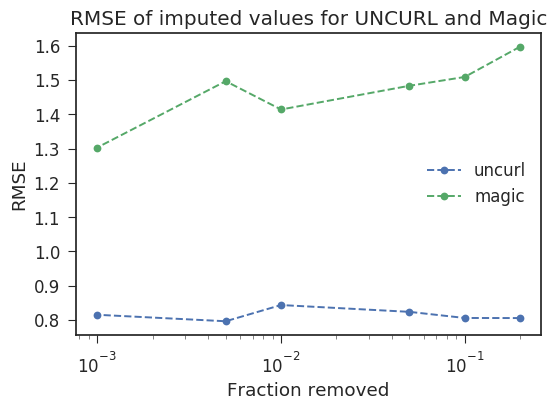

In [108]:
plt.figure(dpi=100)
plt.semilogx(uncurl_rmse_10x.p_impute, uncurl_rmse_10x.value, '--o', label='uncurl')
plt.semilogx(magic_rmse_10x.p_impute, magic_rmse_10x.value, '--o', label='magic')
plt.legend()
plt.title('RMSE of imputed values for UNCURL and Magic')
plt.xlabel('Fraction removed')
plt.ylabel('RMSE')

Text(0,0.5,'Correlation')

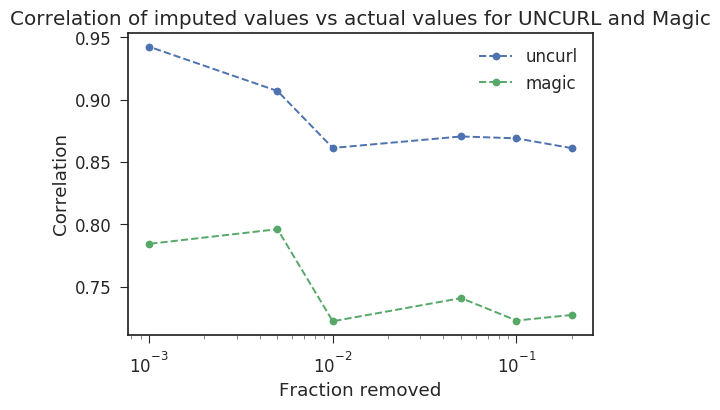

In [109]:
plt.figure(dpi=100)
plt.semilogx(uncurl_corr_10x.p_impute, uncurl_corr_10x.value, '--o', label='uncurl')
plt.semilogx(magic_corr_10x.p_impute, magic_corr_10x.value, '--o', label='magic')
plt.legend()
plt.title('Correlation of imputed values vs actual values for UNCURL and Magic')
plt.xlabel('Fraction removed')
plt.ylabel('Correlation')

Text(0,0.5,'Spearman Correlation')

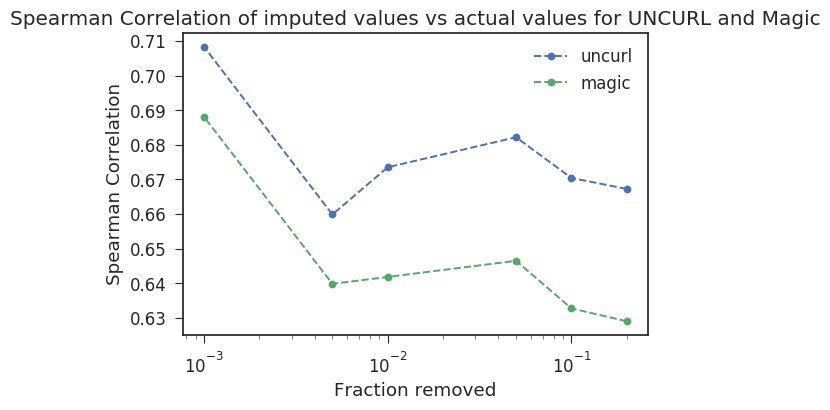

In [110]:
plt.figure(dpi=100)

plt.semilogx(uncurl_sp_10x.p_impute, uncurl_sp_10x.value, '--o', label='uncurl')
plt.semilogx(magic_sp_10x.p_impute, magic_sp_10x.value, '--o', label='magic')
plt.legend()
plt.title('Spearman Correlation of imputed values vs actual values for UNCURL and Magic')
plt.xlabel('Fraction removed')
plt.ylabel('Spearman Correlation')

Text(0,0.5,'RMSE')

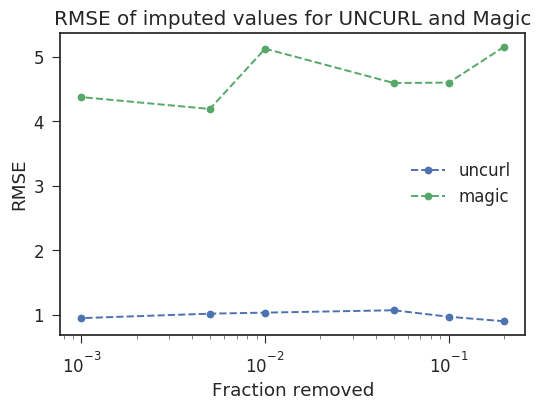

In [111]:
plt.figure(dpi=100)

plt.semilogx(uncurl_rmse_z.p_impute, uncurl_rmse_z.value, '--o', label='uncurl')
plt.semilogx(magic_rmse_z.p_impute, magic_rmse_z.value, '--o', label='magic')
plt.legend()
plt.title('RMSE of imputed values for UNCURL and Magic')
plt.xlabel('Fraction removed')
plt.ylabel('RMSE')

Text(0,0.5,'Correlation')

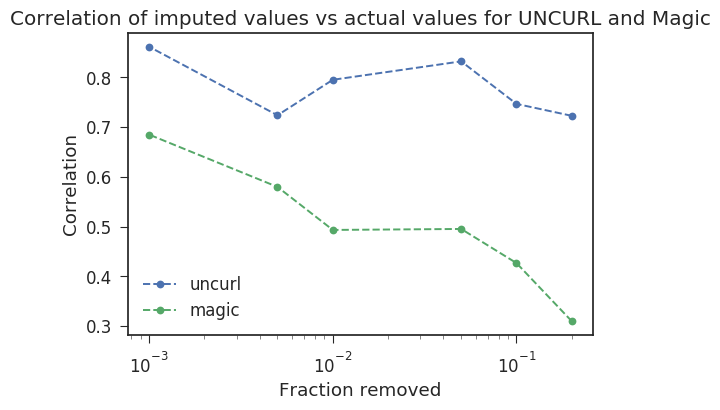

In [112]:
plt.figure(dpi=100)

plt.semilogx(uncurl_corr_z.p_impute, uncurl_corr_z.value, '--o', label='uncurl')
plt.semilogx(magic_corr_z.p_impute, magic_corr_z.value, '--o', label='magic')
plt.legend()
plt.title('Correlation of imputed values vs actual values for UNCURL and Magic')
plt.xlabel('Fraction removed')
plt.ylabel('Correlation')

Text(0,0.5,'Spearman Correlation')

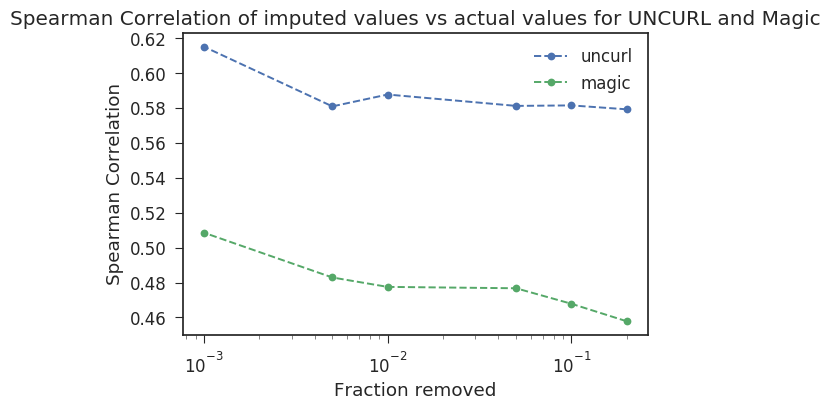

In [113]:
plt.figure(dpi=100)

plt.semilogx(uncurl_sp_z.p_impute, uncurl_sp_z.value, '--o', label='uncurl')
plt.semilogx(magic_sp_z.p_impute, magic_sp_z.value, '--o', label='magic')
plt.legend()
plt.title('Spearman Correlation of imputed values vs actual values for UNCURL and Magic')
plt.xlabel('Fraction removed')
plt.ylabel('Spearman Correlation')